# Problem Set 3

In [1]:
import numpy as np
import scipy as sp
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve
from scipy.io import loadmat
import matplotlib.tri as tri
import matplotlib.pyplot as plt
import time
import pandas as pd
from IPython.display import display, Latex
import math
import time
# chargement des classes du "problem set 2"
from reduce_basis import *

/home/flecourtier/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Introduction

Nous considérons à nouveau le problème de la conception d'une ailette thermique des "Problem Set 1" et "Problem Set 2". Compte tenu de l'approximation de base réduite mise en oeuvre dans le "Problem Set 2", nous nous tournons vers
l'implémentation des procédures associées d'estimation d'erreur a posteriori développées dans le cours. La seconde moitié de ce problème est consacrée à l'implémentation de "greedy sampling procedure". Nous allons considérer les deux cas suivants :

* **Cas 1 (P=1) :**

    On garde le nombre de Biot fixe à $Bi=0.1$ et on assume que les conductivités sur toutes les ailettes sont équivalentes c'est-à-dire $k=k_1=k_2=k_3=k_4$ mais peuvent variées entre 0.1 et 10, on a donc $\mu\in D=[0.1,10]$. 
    
    Pour ce premier cas, nous définissons le produit scalaire sur $X$ par $(\cdot,\cdot)_X=a(\cdot,\cdot,\bar{\mu})$ où $\bar{\mu}=1$.

* **Cas 2 (P=1) :**

    On assume de nouveau que les conductivités sur toutes les ailettes sont équivalentes c'est-à-dire $k=k_1=k_2=k_3=k_4$ mais peuvent variées entre 0.1 et 10 et cette fois-ci le nombre de Biot $Bi$ est également autorisé à varier entre 0.01 et 1. 
    
    On a donc $\mu\in D=[0.1,10]\times [0.01,1]$. 
    
    Pour ce second cas, nous définissons le produit scalaire sur $X$ par $(\cdot,\cdot)_X=a(\cdot,\cdot,\bar{\mu})$ où $\bar{\mu}=(1,0.1)$.

On remarque en fait que dans les deux cas les produits scalaires sur $X$ sont les mêmes.

Nous déffinissons également les grilles de paramètres $G_{[\mu_{min},\mu_{max};M]}^{lin}$ où les M points sont équi-répartis dans $\mu$ et $G_{[\mu_{min},\mu_{max};M]}^{log}$ où les M points sont équi-répartis dans $\log(\mu)$. Ainsi

* Dans le **Cas 1**, on définira 
    $$\Xi_M^{test}=G_{[\mu_{min},\mu_{max};M]}^{lin}\cup G_{[\mu_{min},\mu_{max};M]}^{log}$$
    A noter que $\Xi_M^{test}$ contient $2M$ points.

* Dans le **Cas 2**, on définira 
    $$\Xi_M^{test}=\Xi_M^{lin} \cup \Xi_M^{log}$$
    avec
    $$\Xi_M^{lin}=G_{[k_{min},k_{max};M]}^{lin}\times G_{[Bi_{min},Bi_{max};M]}^{lin}, \quad \Xi_M^{log}=G_{[k_{min},k_{max};M]}^{log}\times G_{[Bi_{min},Bi_{max};M]}^{log}$$
    A noter que $\Xi_M^{lin}$ et $\Xi_M^{log}$ contiennent chacun $M^2$ points et donc $\Xi_M^{test}$ contient $2M^2$ points.

## Classes et fonctions

Dans cette section, il y a les fonctions suivantes : 
* *compute_theta_q_mu* -> calcule $\theta_q(\mu)$
* *compute_alpha_LB* -> calcule la borne inférieure de coercivité : $\alpha_{LB}(\mu)$
* *compute_gamma_UB* -> calcule la borne supérieure de continuité : $\gamma_{UB}(\mu)$
* *compute_eff_en_bound* -> calcule la borne de l'effectivité associée à la norme d'énergie : $\eta_{N}^{en}(\mu)\le\sqrt{\frac{\gamma_{UB}(\mu)}{\alpha_{LB}(\mu)}}$
* *compute_eff_out_bound* -> calcule la borne de l'effectivité associée à la sortie : $\eta_{N}^{s}(\mu)\le\frac{\gamma_{UB}(\mu)}{\alpha_{LB}(\mu)}$

Ces fonctions seront expliquées et utilisées dans la suite.

In [2]:
mu_prod = np.array([1., 1., 1., 1., 1., 0.1])

def compute_theta_q_mu(q,mu):
    assert(1<=q and q<=6)
    return mu[q-1]

def compute_alpha_LB(mu):
    tab_alpha_LB = np.zeros(6)
    for q in range(6):
        tab_alpha_LB[q] = compute_theta_q_mu(q+1,mu) / compute_theta_q_mu(q+1,mu_prod) 
    return np.min(tab_alpha_LB)

def compute_gamma_UB(mu):
    tab_gamma_UB = np.zeros(6)
    for q in range(6):
        tab_gamma_UB[q] = compute_theta_q_mu(q+1,mu) / compute_theta_q_mu(q+1,mu_prod) 
    return np.max(tab_gamma_UB)

def compute_eff_en_bound(mu):
    alpha_LB = compute_alpha_LB(mu)
    gamma_UB = compute_gamma_UB(mu)
    return np.sqrt(gamma_UB / alpha_LB)

def compute_eff_out_bound(mu):
    alpha_LB = compute_alpha_LB(mu)
    gamma_UB = compute_gamma_UB(mu)
    return gamma_UB / alpha_LB

### Méthode directe

La classe suivante regroupe les méthodes utiles à la méthode directe, méthode expliquée dans le Partie 2. 

In [3]:
class direct_method():
    def __init__(self, modele):
        self.modele = modele
    
    def compute_R_mu(self,mu):
        U_N = self.modele.get_u_N(mu)
        R_mu = self.modele.F_N_cal - self.modele.get_A_N_cal(mu) @ self.modele.Z @ U_N
        return R_mu

    def compute_Delta_N_en(self,mu):
        R_mu = self.compute_R_mu(mu)
        E_hat_mu = spsolve(self.modele.A_prod, R_mu)
        norm_residual = self.modele.norme(E_hat_mu)
        alpha_LB = compute_alpha_LB(mu)
        Delta_N_en_mu = norm_residual/np.sqrt(alpha_LB)
        return Delta_N_en_mu

    def en_effectivity(self,mu):
        A_N_cal_mu = self.modele.get_A_N_cal(mu)
        u_N_cal_mu = self.modele.get_u_N_cal(mu)
        u_N_mu = self.modele.get_u_N(mu)
        e_mu = u_N_cal_mu - self.modele.Z @ u_N_mu
        norm_e_mu = np.sqrt(e_mu.T @ A_N_cal_mu @ e_mu)

        Delta_N_en_mu = self.compute_Delta_N_en(mu)
        exclude = (norm_e_mu<=1e-8)
        return Delta_N_en_mu/norm_e_mu,exclude

### Méthode offline/online

La classe suivante regroupe les méthodes utiles à la méthode offline-online, méthode expliquée dans le Partie 2. 

In [4]:
class offline_online_method():
    def __init__(self, modele):
        self.modele = modele
    
    def compute_norm_residual(self,mu,Q_1,Q_2,Q_3):
        val = Q_1.copy()
        u_N_mu = self.modele.get_u_N(mu)
        for q in range(6):
            theta_q_mu = compute_theta_q_mu(q+1,mu)

            val2 = 2 * Q_2[q]
            for q2 in range(6):
                theta_q2_mu = compute_theta_q_mu(q2+1,mu)
                val2 += theta_q2_mu * Q_3[q2][q] @ u_N_mu

            val += theta_q_mu * u_N_mu.T @ val2
        return np.sqrt(val)

    def compute_Delta_N_en(self,mu,Q_1,Q_2,Q_3):
        norm_residual = self.compute_norm_residual(mu,Q_1,Q_2,Q_3)
        alpha_LB = compute_alpha_LB(mu)
        Delta_N_en_mu = norm_residual/np.sqrt(alpha_LB)
        return Delta_N_en_mu

    def en_effectivity(self,mu,Q_1,Q_2,Q_3):
        A_N_cal_mu = self.modele.get_A_N_cal(mu)
        u_N_cal_mu = self.modele.get_u_N_cal(mu)
        u_N_mu = self.modele.get_u_N(mu)
        e_mu = u_N_cal_mu - self.modele.Z @ u_N_mu
        norm_e_mu = np.sqrt(e_mu.T @ A_N_cal_mu @ e_mu)

        Delta_N_en_mu = self.compute_Delta_N_en(mu,Q_1,Q_2,Q_3)
        exclude = (norm_e_mu<=1e-7)
        return Delta_N_en_mu/norm_e_mu,exclude

    def compute_Delta_N_s(self,mu,Q_1,Q_2,Q_3):
        Delta_N_en_mu = self.compute_Delta_N_en(mu,Q_1,Q_2,Q_3)
        return Delta_N_en_mu**2

    def s_effectivity(self,mu,Q_1,Q_2,Q_3):
        Delta_N_s_mu = self.compute_Delta_N_s(mu,Q_1,Q_2,Q_3)
        
        s_N_cal = self.modele.get_T_root_N_cal(mu)
        s_N = self.modele.get_T_root_N(mu)
        diff_output = np.abs(s_N_cal-s_N)

        exclude = (diff_output<=1e-11)
        return Delta_N_s_mu/diff_output,exclude
    
    def offline_quantity(self):
        C = spsolve(self.modele.A_prod, self.modele.F_N_cal) # de taille N_cal
        A_q = np.array([-spsolve(self.modele.A_prod, self.modele.A_N_cal_q[q] @ self.modele.Z) for q in range(6)]) # 6 matrices de taille N_cal*N

        Q_1 = np.array(self.modele.prod_scalaire(C,C)) # scalaire
        Q_2 = np.array([self.modele.prod_scalaire(A_q[q],C) for q in range(6)]) # Q=6 vecteurs de taille N
        Q_3 = np.array([[self.modele.prod_scalaire(A_q[q2],A_q[q]) for q in range(6)] for q2 in range(6)]) # 6*6 matrices de taille N*N

        if(self.modele.Z.shape[1]==1):
            Q_2 = Q_2[:,np.newaxis]
            Q_3 = Q_3[:,:,np.newaxis]

        return Q_1,Q_2,Q_3

## Part 1 - Coercivity Lower Bound and X-Norm error bound

### Question 1

Comme notre problème est paramétriquement coercif, la simple approche min-$\theta$ suffit pour la construction de la borne inférieure de la coercivité $\alpha_{LB}(\mu)$.

#### Question a

##### Expression $\alpha_{LB}(\mu)$

Déterminons une expression explicite pour $\alpha_{LB}(\mu)$ dans les 2 cas présentés ci-dessus.

Tout d'abord, appliquons la méthode min-$\theta$ :

$$\begin{aligned}
    \alpha(\mu)&=\inf_{v\in X}\frac{a(v,v;\mu)}{||v||_X^2} \\
    &=\inf_{v\in X} \sum_{q=1}^Q\frac{\theta_q(\mu)a^q(v,v)}{||v||_X^2} \\
    &=\inf_{v\in X} \sum_{q=1}^Q\frac{\theta_q(\mu)\theta_q(\bar{\bar{\mu}})a^q(v,v)}{\theta_q(\bar{\bar{\mu}})||v||_X^2} \\
    &\ge \min_q \frac{\theta_q(\mu)}{\theta_q(\bar{\bar{\mu}})} \inf_{v\in X}\sum_{q=1}^Q\frac{\theta_q(\bar{\bar{\mu}})a^q(v,v)}{||v||_X^2} \\
    &\ge \min_q \frac{\theta_q(\mu)}{\theta_q(\bar{\bar{\mu}})} \alpha(\bar{\bar{\mu}}) = \alpha_{LB}(\mu)
\end{aligned}$$

Donc
$$\boxed{\alpha_{LB}(\mu) = \min_q \frac{\theta_q(\mu)}{\theta_q(\bar{\bar{\mu}})} \alpha(\bar{\bar{\mu}})}$$

Nous prendrons dans la suite $\bar{\bar{\mu}}=\bar{\mu}$ et donc
$$\alpha(\bar{\bar{\mu}})=\alpha(\bar{\mu})=\inf_{v\in X}\frac{a(v,v;\bar{\mu})}{||v||_X^2}=\inf_{v\in X}\frac{||v||_X^2}{||v||_X^2}=1$$

Ainsi

* Dans le **Cas 1**, on a $\quad \mu=(k,0.1), \quad \bar{\bar{\mu}}=\bar{\mu}=(1,0.1) \quad $ ainsi
    $$\theta_q({\mu})=\left\{
        \begin{aligned}
            &k \quad &&\text{si } q=1,\dots,4 \\
            &k_0=1 \quad &&\text{si } q=5 \\
            &0.1 \quad &&\text{si } q=6 \\
        \end{aligned}
    \right., \qquad \theta_q(\bar{\bar{\mu}})=\left\{
        \begin{aligned}
            &1 \quad &&\text{si } q=1,\dots,4 \\
            &k_0=1 \quad &&\text{si } q=5 \\
            &0.1 \quad &&\text{si } q=6 \\
        \end{aligned}
    \right.$$

    Donc 
    $$\alpha_{LB}(\mu) = \min_q \frac{\theta_q(\mu)}{\theta_q(\bar{\bar{\mu}})}=\min\{k,1\}$$

* Dans le **Cas 2**, on a $\quad \mu=(k,Bi), \quad \bar{\bar{\mu}}=\bar{\mu}=(1,0.1) \quad $ ainsi
    $$\theta_q({\mu})=\left\{
        \begin{aligned}
            &k \quad &&\text{si } q=1,\dots,4 \\
            &k_0=1 \quad &&\text{si } q=5 \\
            &Bi \quad &&\text{si } q=6 \\
        \end{aligned}
    \right., \qquad \theta_q(\bar{\bar{\mu}})=\left\{
        \begin{aligned}
            &1 \quad &&\text{si } q=1,\dots,4 \\
            &k_0=1 \quad &&\text{si } q=5 \\
            &0.1 \quad &&\text{si } q=6 \\
        \end{aligned}
    \right.$$

    Donc 
    $$\alpha_{LB}(\mu) = \min_q \frac{\theta_q(\mu)}{\theta_q(\bar{\bar{\mu}})}=\min\{k,1,10*Bi\}$$

##### Expression $\gamma_{UB}(\mu)$

De la même manière, déterminons une expression explicite pour $\gamma_{UB}(\mu)$.

$$\begin{aligned}
    \gamma(\mu)&=\sup_{w\in X}\sup_{v\in X}\frac{a(w,v;\mu)}{||w||_X||v||_X} \\
    &=\sup_{w\in X}\sup_{v\in X} \sum_{q=1}^Q\frac{\theta_q(\mu)a^q(w,v)}{||w||_X||v||_X} \\
    &=\sup_{w\in X}\sup_{v\in X} \sum_{q=1}^Q\frac{\theta_q(\mu)\theta_q(\bar{\bar{\mu}})a^q(w,v)}{\theta_q(\bar{\bar{\mu}})||w||_X||v||_X} \\
    &\le \max_q \frac{\theta_q(\mu)}{\theta_q(\bar{\bar{\mu}})} \sup_{w\in X}\sup_{v\in X}\sum_{q=1}^Q\frac{\theta_q(\bar{\bar{\mu}})a^q(w,v)}{||w||_X||v||_X} \\
    &\le \max_q \frac{\theta_q(\mu)}{\theta_q(\bar{\bar{\mu}})} \gamma(\bar{\bar{\mu}}) = \gamma_{UB}(\mu)
\end{aligned}$$

Donc
$$\boxed{\gamma_{UB}(\mu) = \max_q \frac{\theta_q(\mu)}{\theta_q(\bar{\bar{\mu}})} \gamma(\bar{\bar{\mu}})}$$

Comme nous prenons $\bar{\bar{\mu}}=\bar{\mu}$ on a
$$\gamma(\bar{\bar{\mu}})=\gamma(\bar{\mu})=\sup_{w\in X}\sup_{v\in X}\frac{a(w,v;\bar{\mu})}{||w||_X||v||_X}$$

Or par Cauchy-Shwartz
$$a(w,v,\bar{\mu})=(w,v)_X\le ||w||_X||v||_X \quad \Rightarrow \quad \gamma(\bar{\mu})\le \sup_{w\in X}\sup_{v\in X}\frac{||w||_X||v||_X}{||w||_X||v||_X}=1$$

En prenant $w=v$, on obtient 
$$\frac{a(w,v;\bar{\mu})}{||w||_X||v||_X}=\frac{a(v,v;\bar{\mu})}{||v||_X^2}=1$$
Donc la borne supérieure est atteinte et on en déduit que $\gamma(\bar{\bar{\mu}})=1$

Ainsi

* Dans le **Cas 1**, on a $\quad \mu=(k,0.1), \quad \bar{\bar{\mu}}=\bar{\mu}=(1,0.1) \quad $ ainsi
    $$\theta_q({\mu})=\left\{
        \begin{aligned}
            &k \quad &&\text{si } q=1,\dots,4 \\
            &k_0=1 \quad &&\text{si } q=5 \\
            &0.1 \quad &&\text{si } q=6 \\
        \end{aligned}
    \right., \qquad \theta_q(\bar{\bar{\mu}})=\left\{
        \begin{aligned}
            &1 \quad &&\text{si } q=1,\dots,4 \\
            &k_0=1 \quad &&\text{si } q=5 \\
            &0.1 \quad &&\text{si } q=6 \\
        \end{aligned}
    \right.$$

    Donc 
    $$\gamma_{UB}(\mu) =  \max_q \frac{\theta_q(\mu)}{\theta_q(\bar{\bar{\mu}})}=\max\{k,1\}$$

* Dans le **Cas 2**, on a $\quad \mu=(k,Bi), \quad \bar{\bar{\mu}}=\bar{\mu}=(1,0.1) \quad $ ainsi
    $$\theta_q({\mu})=\left\{
        \begin{aligned}
            &k \quad &&\text{si } q=1,\dots,4 \\
            &k_0=1 \quad &&\text{si } q=5 \\
            &Bi \quad &&\text{si } q=6 \\
        \end{aligned}
    \right., \qquad \theta_q(\bar{\bar{\mu}})=\left\{
        \begin{aligned}
            &1 \quad &&\text{si } q=1,\dots,4 \\
            &k_0=1 \quad &&\text{si } q=5 \\
            &0.1 \quad &&\text{si } q=6 \\
        \end{aligned}
    \right.$$

    Donc 
    $$\gamma_{UB}(\mu) = \max_q \frac{\theta_q(\mu)}{\theta_q(\bar{\bar{\mu}})}=\max\{k,1,10*Bi\}$$

#### Question b

On cherche maintenant la plus grande effectivité pour la borne d'erreur de la norme d'énergie et pour la borne d'erreur de sortie. On devra distinguer les cas.

On définit $\Delta_N^{en}(\mu)$ la borne d'erreur de la norme d'énergie par :
$$\Delta_N^{en}(\mu)=\frac{\epsilon_N(\mu)}{\sqrt{\alpha_{LB}(\mu)}}$$
avec 
$$\epsilon_N(\mu)=||\hat{e}(\mu)||_X=||r(u_N(\mu),v;\mu)||_{X'}$$
et l'effectivité associée :
$$\eta_{N}^{en}(\mu)=\frac{\Delta_N^{en}(\mu)}{|||e(\mu)|||_\mu}$$
D'après le cours, nous avons la propriété suivante :
$$1\le \eta_{N}^{en}(\mu)\le\sqrt{\frac{\gamma_{UB}(\mu)}{\alpha_{LB}(\mu)}}$$

Ainsi

* Dans le **Cas 1**, on a 

    $$\sqrt{\frac{\gamma_{UB}(\mu)}{\alpha_{LB}(\mu)}}=\sqrt{\frac{\gamma(\bar{\bar{\mu}})\max\{k,1\}}{\min\{k,1\}}}= \sqrt{\frac{\max\{k,1\}}{\min\{k,1\}}}=\left\{
    \begin{aligned}
        \sqrt{1/k} \quad \text{si } k\le 1 \\
        \sqrt{k} \quad \text{si } k>1
    \end{aligned}
    \right.\le\sqrt{10}$$

    car k est compris entre 0.1 et 10.

* Dans le **Cas 2**, on a 

    $$\sqrt{\frac{\gamma_{UB}(\mu)}{\alpha_{LB}(\mu)}}=\sqrt{\frac{\gamma(\bar{\bar{\mu}})\max\{k,1,10*Bi\}}{\min\{k,1,10*Bi\}}}= \sqrt{\frac{\max\{k,1,10*Bi\}}{\min\{k,1,10*Bi\}}}\le\sqrt{\frac{10}{0.1}}=\sqrt{100}=10$$

    Car comme $0.1\le k\le 1$ et $0.01\le Bi\le 1$ (donc $0.1\le 10Bi\le 10$), on a :
    $$\max\{k,1,10*Bi\}\le 10 \quad \text{et} \quad \min\{k,1,10*Bi\}\ge 0.1$$


On définit $\Delta_N^{s}(\mu)$ la borne d'erreur de sortie par :
$$\Delta_N^{s}(\mu)=\Delta_N^{en}(\mu)^2$$

et l'effectivité associée :
$$\eta_{N}^{s}(\mu)=\frac{\Delta_N^{s}(\mu)}{s(\mu)-s_N(\mu)}$$

D'après le cours, nous avons la propriété suivante :
$$1\le \eta_{N}^{s}(\mu)\le\frac{\gamma_{UB}(\mu)}{\alpha_{LB}(\mu)}$$

Ainsi, de la même manière

* Dans le **Cas 1**, on a 

    $$\frac{\gamma_{UB}(\mu)}{\alpha_{LB}(\mu)}=\frac{\gamma(\bar{\bar{\mu}})\max\{k,1\}}{\min\{k,1\}}=\frac{\max\{k,1\}}{\min\{k,1\}}\le 10$$

* Dans le **Cas 2**, on a 

    $$\frac{\gamma_{UB}(\mu)}{\alpha_{LB}(\mu)}=\frac{\gamma(\bar{\bar{\mu}})\max\{k,1,10*Bi\}}{\min\{k,1,10*Bi\}}=\frac{\max\{k,1,10*Bi\}}{\min\{k,1,10*Bi\}}\le 100$$


### Question 2

Nous considérons l'effectivité relative de la sortie, définie par
$$\eta_N(\mu)=\frac{\Delta_N(\mu)}{||e(\mu)||_X}=\frac{\Delta_N(\mu)}{||u(\mu)-u_N(\mu)||_X}$$
avec
$$\Delta_N(\mu)=\frac{||\hat{e}(\mu)||_X}{\alpha_{LB}(\mu)}$$
où $\hat{e}(\mu)\in X$ satisfait
$$(\hat{e}(\mu),v)_X=r(u_N(\mu),v;\mu)=a(e(\mu),v,\mu)$$
On cherche à démontrer la propriété suivante
$$1\le \eta_N(\mu)\le \frac{\gamma_{UB}(\mu)}{\alpha_{LB}(\mu)}\quad\forall\mu\in D$$

* Comme $a$ est coercive :
    $$a(e(\mu),e(\mu),\mu)\ge \alpha(\mu)||e(\mu)||_X^2\ge \alpha_{LB}(\mu)||e(\mu)||_X^2$$
    et
    $$r(u_N(\mu),e(\mu),\mu)\le ||\hat{e}(\mu)||_X||e(\mu)||_X$$
    Donc
    $$||\hat{e}(\mu)||_X\ge \alpha_{LB}(\mu)||e(\mu)||_X \quad \Rightarrow \quad ||e(\mu)||_X\le\frac{||\hat{e}(\mu)||_X}{\alpha_{LB}(\mu)}$$
    On en déduit
    $$\eta_N(\mu)=\frac{\Delta_N(\mu)}{||e(\mu)||_X}=\frac{||\hat{e}(\mu)||_X}{\alpha_{LB}(\mu)||e(\mu)||_X}\ge 1$$

* Comme $a$ est continue
    $$||\hat{e}(\mu)||_X^2=a(e(\mu),\hat{e}(\mu);\mu)\le \gamma(\mu)||e(\mu)||_X||\hat{e}(\mu)||_X\le \gamma_{UB}(\mu)||e(\mu)||_X||\hat{e}(\mu)||_X$$
    Donc
    $$||\hat{e}(\mu)||_X\le \gamma_{UB}(\mu)||e(\mu)||_X$$
    On en déduit
    $$\eta_N(\mu)=\frac{\Delta_N(\mu)}{||e(\mu)||_X}=\frac{||\hat{e}(\mu)||_X}{\alpha_{LB}(\mu)||e(\mu)||_X}\le\frac{\gamma_{UB}(\mu)||e(\mu)||_X}{\alpha_{LB}(\mu)||e(\mu)||_X}=\frac{\gamma_{UB}(\mu)}{\alpha_{LB}(\mu)}$$

## Part 2 - A Posteriori Error Estimation

Dans le suite, on prendra $\bar{\bar{\mu}}=\bar{\mu}$ et donc $\alpha(\bar{\bar{\mu}})=1$ et $\gamma(\bar{\bar{\mu}})=1$. 

Toutes les fonctions/classes utilies à l'implémentations se trouvent dans la section **Classes et fonctions** au-dessus. 

Elles sont complétées au fur et à mesure des questions.

### Question 3

In [5]:
# Case 1
def construct_mu(k_i):
    Bi = 0.1
    assert(k_i >= 0.1 and k_i <= 10)
    return np.array([k_i, k_i, k_i, k_i, 1., Bi])

D=[0.1,10]
type='medium'
sample = 1
ortho = True
modele = reduce_basis(type,sample,mu_prod,ortho)

#### Question a

Borne d'erreur de la norme d'énergie :
$$\boxed{\Delta_N^{en}(\mu)=\frac{\epsilon_N(\mu)}{\sqrt{\alpha_{LB}(\mu)}}}$$
avec 
$$\epsilon_N(\mu)=||\hat{e}(\mu)||_X=||r(u_N(\mu),v;\mu)||_{X'}, \qquad \alpha_{LB}(\mu)=\min_q\frac{\theta_q(\mu)}{\theta_q(\bar{\bar{\mu}})}\alpha(\bar{\bar{\mu}})$$

On veut montrer ici que la méthode direct et la méthode offline/online nous donne les mêmes résultats pour cette borne d'erreur. 

##### Calcul direct :

Par le théorème de représentation de Riesz, on sait qu' $\exists ! \hat{e}\in X, \forall v\in X$
$$(\hat{e}(\mu),v)_X=r(u_N(\mu),v;\mu)$$
et le résidu est donné par
$$r(u_N(\mu),v;\mu)=f(v;\mu)-a(u_N(\mu),v,\mu)$$

Le problème consiste alors à trouver $\hat{E}\in\mathbb{R}^\mathcal{N}$ tel que
$$A_\mathcal{N}(\bar{\mu})\hat{E}=F^\mathcal{N}-A_\mathcal{N}(\mu)ZU_N$$
Et ainsi
$$||r(u_N(\mu),v;\mu)||_{X'}=||\hat{e}(\mu)||_X=\sqrt{(\hat{e}(\mu),\hat{e}(\mu))_X}=\sqrt{(A_\mathcal{N}(\bar{\mu})^{-1}R_\mu,A_\mathcal{N}(\bar{\mu})^{-1}R_\mu)_X}$$
avec
$$R_\mu = F^\mathcal{N}-A_\mathcal{N}(\mu)ZU_N$$

In [6]:
direct = direct_method(modele)

tab_k_i=np.sort(np.random.uniform(low=D[0], high=D[1], size=(5,)))
tab_N = np.arange(1,modele.N+1,1)
res = np.zeros((modele.N,5))

for (i,n) in enumerate(tab_N):
    modele.change_N(n)
    for (j,k_i) in enumerate(tab_k_i):
        mu = construct_mu(k_i)
        Delta_N_en_mu = direct.compute_Delta_N_en(mu)
        res[i,j] = Delta_N_en_mu

display(Latex('Calcul direct de $\Delta_N^{en}(\mu)$ pour différentes valeurs de $\mu$ et différents $N$ :'))
df_direct = pd.DataFrame(data=res,index=tab_N,columns=tab_k_i)
df_direct.columns = ["k_i = " + str(np.round(k_i,4)) for k_i in tab_k_i]
df_direct.index = ["N = " + str(n) for n in tab_N]
df_direct
        

<IPython.core.display.Latex object>

,k_i = 1.2591,k_i = 3.9454,k_i = 4.3805,k_i = 4.7091,k_i = 7.3486
N = 1,0.792241,1.201056e+00,1.228867,1.247063,1.341258
N = 2,0.231037,1.913176e-01,0.179023,0.169414,0.086868
N = 3,0.073185,8.240662e-02,0.078367,0.074934,0.040473
N = 4,0.009958,1.998593e-06,0.000631,0.000992,0.001593
N = 5,0.004344,1.140111e-06,0.000365,0.000579,0.000973
N = 6,0.000666,2.682999e-07,0.000088,0.000141,0.000253
N = 7,0.000051,1.881342e-08,0.000007,0.000012,0.000031
N = 8,0.000015,6.181997e-09,0.000002,0.000004,0.000010


##### Offline-Online :

Le problème consiste toujours à trouver $\hat{E}\in\mathbb{R}^\mathcal{N}$ tel que
$$A_\mathcal{N}(\bar{\mu})\hat{E}=F^\mathcal{N}-A_\mathcal{N}(\mu)ZU_N$$
Dans la suite nous noterons $\mathbb{X}^\mathcal{N}:=A_\mathcal{N}(\bar{\mu})$ la matrice associé au produit scalaire $(\cdot,\cdot)_X$. Donc le problème se réecrit :
$$\mathbb{X}^\mathcal{N}\hat{E}=F^\mathcal{N}-A_\mathcal{N}(\mu)ZU_N$$
On utilise maintenant la décomposition affine :
$$A_\mathcal{N}(\mu)=\sum_{q=1}^{Q}\theta_q(\mu) A_\mathcal{N}^q$$
Donc
$$\mathbb{X}^\mathcal{N}\hat{E}=F^\mathcal{N}-\sum_{q=1}^{Q}\theta_q(\mu) A_\mathcal{N}^qZU_N$$

On peut maintenant effectuer les étapes suivantes :

* offline :

    * Trouver $C\in\mathbb{R}^\mathcal{N}$ tel que
        $$\mathbb{X}^\mathcal{N}C = F^\mathcal{N}$$
    * Trouver $A_q\in\mathbb{R}^{\mathcal{N}\times N}$ ($1\le q\le Q$) tel que
        $$\mathbb{X}^\mathcal{N}A_q = -A_\mathcal{N}^qZ$$
    * Stocker les quantités suivantes :
        $$C^T\mathbb{X}^\mathcal{N}C\in\mathbb{R}$$
        $$(A_q)^T\mathbb{X}^\mathcal{N}C\in\mathbb{R}^N, \quad 1\le q\le Q$$
        $$(A_{q'})^T\mathbb{X}^\mathcal{N}A_q\in\mathbb{R}^{N\times N}, \quad 1\le q,q'\le Q$$
* online :
    $$||\hat{e}(\mu)||_X^2 = \color{blue}{C^T\mathbb{X}^\mathcal{N}C}\color{black}+\sum_{q=1}^Q \theta_q(\mu)U_N^T\left[2\color{blue}A_q^T\mathbb{X}^\mathcal{N} C\color{black}+\sum_{q'=1}^Q\theta_{q'}(\mu)\color{blue}(A_{q'})^T\mathbb{X}^\mathcal{N}A_q\color{black}U_N\right]$$

    où les valeurs en bleues sont les quantités calculées précédement dans la partie offline.

    En effet, on a :

    $$\begin{aligned}
        ||\hat{e}(\mu)||_X^2&=\left|\left|(\mathbb{X}^\mathcal{N})^{-1}\left(F^\mathcal{N}-\sum_{q=1}^{Q}\theta_q(\mu) A_\mathcal{N}^qZU_N\right)\right|\right|_X^2 \\
        &=\left|\left|C+\sum_{q=1}^{Q}\theta_q(\mu) A_qU_N\right|\right|_X^2 \\
        &=\left(C+\sum_{q=1}^{Q}\theta_q(\mu) A_qU_N,C+\sum_{q'=1}^{Q}\theta_{q'}(\mu) A_{q'}U_N\right)_X \\
        &=(C,C)_X+\sum_{q=1}^{Q}\theta_q(\mu) (A_qU_N,C)_X+\sum_{q'=1}^{Q}\theta_{q'}(\mu) (A_{q'}U_N,C)_X+\sum_{q=1}^{Q}\theta_q(\mu)\sum_{q'=1}^{Q}\theta_{q'}(\mu) (A_qU_N,A_{q'}U_N)_X \\
        &=(C,C)_X+2\sum_{q=1}^{Q}\theta_q(\mu) (A_qU_N,C)_X+\sum_{q=1}^{Q}\theta_q(\mu)\sum_{q'=1}^{Q}\theta_{q'}(\mu) (A_qU_N,A_{q'}U_N)_X \\
        &=(C,C)_X+\sum_{q=1}^{Q}\theta_q(\mu) \left[2(A_qU_N,C)_X+\sum_{q'=1}^{Q}\theta_{q'}(\mu) (A_qU_N,A_{q'}U_N)_X\right] \\
        &={C^T\mathbb{X}^\mathcal{N}C}+\sum_{q=1}^Q \theta_q(\mu)U_N^T\left[2A_q^T\mathbb{X}^\mathcal{N} C+\sum_{q'=1}^Q\theta_{q'}(\mu)(A_{q'})^T\mathbb{X}^\mathcal{N}A_qU_N\right]
    \end{aligned}$$

On pourra ainsi en déduire la borne d'erreur de la norme d'énergie.


In [7]:
offline_online = offline_online_method(modele)

res = np.zeros((modele.N,5))

for (i,n) in enumerate(tab_N):
    modele.change_N(n)
    Q_1,Q_2,Q_3 = offline_online.offline_quantity()

    for (j,k_i) in enumerate(tab_k_i):
        mu = construct_mu(k_i)
        Delta_N_en_mu = offline_online.compute_Delta_N_en(mu,Q_1,Q_2,Q_3)
        res[i,j] = Delta_N_en_mu

display(Latex('Calcul offline/online de $\Delta_N^{en}(\mu)$ pour différentes valeurs de $\mu$ et différents $N$ :'))
df_offline_online = pd.DataFrame(data=res,index=tab_N,columns=tab_k_i)
df_offline_online.columns = ["k_i = " + str(np.round(k_i,4)) for k_i in tab_k_i]
df_offline_online.index = ["N = " + str(n) for n in tab_N]
df_offline_online


<IPython.core.display.Latex object>

,k_i = 1.2591,k_i = 3.9454,k_i = 4.3805,k_i = 4.7091,k_i = 7.3486
N = 1,0.792241,1.201056e+00,1.228867,1.247063,1.341258
N = 2,0.231037,1.913176e-01,0.179023,0.169414,0.086868
N = 3,0.073185,8.240662e-02,0.078367,0.074934,0.040473
N = 4,0.009958,1.998812e-06,0.000631,0.000992,0.001593
N = 5,0.004344,1.140401e-06,0.000365,0.000579,0.000973
N = 6,0.000666,2.698715e-07,0.000088,0.000141,0.000253
N = 7,0.000051,2.885597e-08,0.000007,0.000012,0.000031
N = 8,0.000015,2.107342e-08,0.000002,0.000004,0.000010


##### Comparaison des 2 méthodes

In [8]:
print("Comparaison des deux méthodes :")
# argument result_names disponible à partir de pandas 1.5.2
df_direct.compare(df_offline_online,result_names=('direct', 'off/on'))

Comparaison des deux méthodes :


k_i = 1.2591            k_i = 3.9454               k_i = 4.3805  \
            direct    off/on        direct        off/on       direct   
N = 1     0.792241  0.792241  1.201056e+00  1.201056e+00     1.228867   
N = 2     0.231037  0.231037  1.913176e-01  1.913176e-01     0.179023   
N = 3     0.073185  0.073185  8.240662e-02  8.240662e-02     0.078367   
N = 4     0.009958  0.009958  1.998593e-06  1.998812e-06     0.000631   
N = 5     0.004344  0.004344  1.140111e-06  1.140401e-06     0.000365   
N = 6     0.000666  0.000666  2.682999e-07  2.698715e-07     0.000088   
N = 7     0.000051  0.000051  1.881342e-08  2.885597e-08     0.000007   
N = 8     0.000015  0.000015  6.181997e-09  2.107342e-08     0.000002   

                k_i = 4.7091           k_i = 7.3486            
         off/on       direct    off/on       direct    off/on  
N = 1  1.228867     1.247063  1.247063     1.341258  1.341258  
N = 2  0.179023     0.169414  0.169414     0.086868  0.086868  
N = 3  0.078367     0.074934  0.074934     0.040473  0.040473  
N = 4  0.000631     0.000992  0.000992     0.001593  0.001593  
N = 5  0.000365     0.000579  0.000579     0.000973  0.000973  
N = 6  0.000088     0.000141  0.000141     0.000253  0.000253  
N = 7  0.000007     0.000012  0.000012     0.000031  0.000031  
N = 8  0.000002     0.000004  0.000004     0.000010  0.000010

In [9]:
print("Différence maximale (en valeur abs) des 2 méthodes :",(df_direct-df_offline_online).abs().max().max())

Différence maximale (en valeur abs) des 2 méthodes : 1.4891427114352278e-08


Il semblerait donc que l'on obtienne bien les mêmes résultats pour la borne d'erreur d'énergie.

#### Question b

On veut maintenant calculer $\eta_{min,N}^{en}$, $\eta_{max,N}^{en}$ et $\eta_{ave,N}^{en}$ respectivement le minimum, le maximum et la moyenne de l'effectivité $\eta_{N}^{en}(\mu)$ sur $\Xi_{test}=G^{lin}[\mu_{min},\mu_{max};50]\cup G^{log}[\mu_{min},\mu_{max};50]$. 

Notons que 
$$\boxed{\eta_{N}^{en}(\mu)=\frac{\Delta_N^{en}(\mu)}{|||e(\mu)|||_\mu}}$$

In [10]:
(mu_min,mu_max) = D
m = 50
G_lin = np.linspace(mu_min,mu_max,m)
G_log = np.logspace(np.log10(mu_min),np.log10(mu_max),m)
xi_test = np.sort(np.concatenate((G_lin,G_log)))

##### Calcul direct :

In [11]:
direct = direct_method(modele)

res = np.zeros((modele.N,4))

for (i,n) in enumerate(tab_N):
    modele.change_N(n)

    tab_eta_mu = []
    tab_mu = []
    for (j,k_i) in enumerate(xi_test):
        mu = construct_mu(k_i)
        eta_mu,exclude = direct.en_effectivity(mu)
        if not exclude:
            tab_eta_mu.append(eta_mu)
            tab_mu.append(mu)

    argmax = np.argmax(tab_eta_mu)           
    eta_min,eta_max,eta_mean,bound = [np.min(tab_eta_mu),np.max(tab_eta_mu),np.mean(tab_eta_mu),compute_eff_en_bound(tab_mu[argmax])]
    res[i,:] = eta_min,eta_max,eta_mean,bound

display(Latex('Calcul direct de $\eta_{N}^{en}(\mu)$ pour différentes valeurs de $\mu\in\Xi_{test}$ et différents $N$ :'))
df_direct = pd.DataFrame(data=res,index=tab_N,columns=['min','max','mean','bound'])
df_direct.index = ["N = " + str(n) for n in tab_N]
df_direct

<IPython.core.display.Latex object>

,min,max,mean,bound
N = 1,1.009650,1.673362,1.238664,3.017115
N = 2,1.008232,2.480684,1.613751,3.130169
N = 3,1.005982,2.632901,1.654871,3.130169
N = 4,1.009582,2.387424,1.591198,3.130169
N = 5,1.005902,2.618966,1.647296,3.130169
N = 6,1.010495,2.328440,1.575181,3.130169
N = 7,1.003658,2.811678,1.702354,3.130169
N = 8,1.006682,2.583938,1.643857,3.130169


##### Offline/Online

In [12]:
offline_online = offline_online_method(modele)

res = np.zeros((modele.N,4))

for (i,n) in enumerate(tab_N):
    modele.change_N(n)
    Q_1,Q_2,Q_3 = offline_online.offline_quantity()

    tab_eta_mu = []
    tab_mu = []
    for (j,k_i) in enumerate(xi_test):
        mu = construct_mu(k_i)
        eta_mu,exclude = offline_online.en_effectivity(mu,Q_1,Q_2,Q_3)
        if not exclude:
            tab_eta_mu.append(eta_mu)
            tab_mu.append(mu)
            
    argmax = np.argmax(tab_eta_mu)           
    eta_min,eta_max,eta_mean,bound = [np.min(tab_eta_mu),np.max(tab_eta_mu),np.mean(tab_eta_mu),compute_eff_en_bound(tab_mu[argmax])]
    res[i,:] = eta_min,eta_max,eta_mean,bound

display(Latex('Calcul offline/online de $\eta_{N}^{en}(\mu)$ pour différentes valeurs de $\mu\in\Xi_{test}$ et différents $N$ :'))
df_offline_online = pd.DataFrame(data=res,index=tab_N,columns=['min','max','mean','bound'])
df_offline_online.index = ["N = " + str(n) for n in tab_N]
df_offline_online


<ipython-input-4-de794dd27933>:17: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(val)


<IPython.core.display.Latex object>

,min,max,mean,bound
N = 1,1.009650,1.673362,1.238664,3.017115
N = 2,1.008232,2.480684,1.613751,3.130169
N = 3,1.005982,2.632901,1.654871,3.130169
N = 4,1.009582,2.387424,1.591198,3.130169
N = 5,1.005902,2.618966,1.647298,3.130169
N = 6,1.010495,2.328440,1.575330,3.130169
N = 7,1.003658,2.811563,1.702017,3.130169
N = 8,1.006686,2.582427,1.655470,3.130169


##### Comparaison des 2 méthodes

In [13]:
print("Comparaison des deux méthodes :")
# argument result_names disponible à partir de pandas 1.5.2
df_direct.compare(df_offline_online,result_names=('direct', 'off/on'),keep_equal=True)

Comparaison des deux méthodes :


min                 max                mean          
         direct    off/on    direct    off/on    direct    off/on
N = 1  1.009650  1.009650  1.673362  1.673362  1.238664  1.238664
N = 2  1.008232  1.008232  2.480684  2.480684  1.613751  1.613751
N = 3  1.005982  1.005982  2.632901  2.632901  1.654871  1.654871
N = 4  1.009582  1.009582  2.387424  2.387424  1.591198  1.591198
N = 5  1.005902  1.005902  2.618966  2.618966  1.647296  1.647298
N = 6  1.010495  1.010495  2.328440  2.328440  1.575181  1.575330
N = 7  1.003658  1.003658  2.811678  2.811563  1.702354  1.702017
N = 8  1.006682  1.006686  2.583938  2.582427  1.643857  1.655470

##### Vérification des résultats

D'après le cours, nous avons la propriété suivante :
$$1\le \eta_{N}^{en}(\mu)\le\sqrt{\frac{\gamma_{UB}(\mu)}{\alpha_{LB}(\mu)}}$$

On constate bien que l'effectivité minimale dans le tableau ci-dessus est supérieur à 1.

Vérifions que l'effectivité est inférieure à la borne pour différents mu :

In [14]:
m = 8
G_lin = np.linspace(mu_min,mu_max,m)
G_log = np.logspace(np.log10(mu_min),np.log10(mu_max),m)
xi_test = np.sort(np.concatenate((G_lin,G_log)))[2:-2]

In [15]:
offline_online = offline_online_method(modele)

major = True
for (i,n) in enumerate(tab_N[tab_N%2==0]):
    modele.change_N(n)
    Q_1,Q_2,Q_3 = offline_online.offline_quantity()

    res = np.zeros((2,len(xi_test)))

    tab_eta_mu = []
    tab_bound = []
    for (j,k_i) in enumerate(xi_test):
        mu = construct_mu(k_i)
        eta_mu,exclude = offline_online.en_effectivity(mu,Q_1,Q_2,Q_3)
        if not exclude:
            tab_eta_mu.append(eta_mu)
            tab_bound.append(compute_eff_en_bound(mu))
            if(tab_eta_mu[-1] > tab_bound[-1]):
                major = False
        else:
            tab_eta_mu.append(None)
            tab_bound.append(None)

    res[0,:] = tab_eta_mu
    res[1,:] = tab_bound

    print("N = ",n)
    df_bound = pd.DataFrame(data=res,index=['effectivity','bound'])
    df_bound.columns = [str(np.round(k_i,2)) for k_i in xi_test]
    display(df_bound)

if(major==True):
    print("Toutes les valeurs de l'effectivité sont inférieures aux bornes.")

N =  2


,0.19,0.37,0.72,1.39,1.51,2.68,2.93,4.34,5.18,5.76,7.17,8.59
effectivity,1.404456,1.214964,1.061875,1.117394,1.151659,1.426046,1.476394,1.735388,1.870553,1.958078,2.156480,2.337050
bound,2.275846,1.637894,1.178769,1.178769,1.230563,1.637894,1.711307,2.083952,2.275846,2.399405,2.677952,2.930139


N =  4


,0.19,0.37,0.72,1.39,1.51,2.68,2.93,4.34,5.18,5.76,7.17,8.59
effectivity,1.490763,1.255227,1.072315,1.107556,1.139055,1.392706,1.439500,1.681357,1.808316,1.890788,2.078489,2.250214
bound,2.275846,1.637894,1.178769,1.178769,1.230563,1.637894,1.711307,2.083952,2.275846,2.399405,2.677952,2.930139


N =  6


,0.19,0.37,0.72,1.39,1.51,2.68,2.93,4.34,5.18,5.76,7.17,8.59
effectivity,1.544923,1.279486,1.079284,1.100942,1.130616,1.371241,1.415897,1.647582,1.769637,1.849039,2.030013,2.195828
bound,2.275846,1.637894,1.178769,1.178769,1.230563,1.637894,1.711307,2.083952,2.275846,2.399405,2.677952,2.930139


N =  8


,0.19,0.37,0.72,1.39,1.51,2.68,2.93,4.34,5.18,5.76,7.17,8.59
effectivity,NaN,1.188296,1.050110,1.128583,1.165910,1.461847,1.515726,1.791718,1.935159,2.028068,2.238809,2.430902
bound,NaN,1.637894,1.178769,1.178769,1.230563,1.637894,1.711307,2.083952,2.275846,2.399405,2.677952,2.930139


Toutes les valeurs de l'effectivité sont inférieures aux bornes.


De plus, on constate que toutes les bornes calculées ici sont inférieures à la borne calculée dans la question 1.b. 
En effet, pour la borne associée à la norme d'énergie, dans le cas 1, cette borne est égale à $\sqrt{10}\approx 3.16$.

#### Question c

Nous allons utiliser dans la suite la méthode offline/online.

On cherche à évaluer l'effectivité pour $\mu=1$ pour $N=1,\dots,8$.

In [16]:
offline_online = offline_online_method(modele)

k_i = 1.
mu = construct_mu(k_i)

res = np.zeros(modele.N)

for (i,n) in enumerate(tab_N):
    modele.change_N(n)
    Q_1,Q_2,Q_3 = offline_online.offline_quantity()

    eta_mu,exclude = offline_online.en_effectivity(mu,Q_1,Q_2,Q_3)
            
    if not exclude:
        res[i] = eta_mu
    else:
        res[i] = math.nan


display(Latex('Calcul offline/online de $\eta_N^{en}(\mu)$ pour $\mu=1$ et différents $N$ :'))
df_offline_online = pd.DataFrame(data=res,index=tab_N).transpose()
df_offline_online.index = ["effectivity"]
df_offline_online.columns = ["N = " + str(n) for n in tab_N]
df_offline_online

<IPython.core.display.Latex object>

,N = 1,N = 2,N = 3,N = 4,N = 5,N = 6,N = 7,N = 8
effectivity,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000003


Il semblerait que pour $\mu=1$, on atteint le minimum des effectivités possibles. Ce qui est cohérent car c'est le $\bar{\mu}$ que l'on a choisit.

#### Question d

On cherche à évaluer l'erreur exacte $||u(\mu)-u_N(\mu)||_X$ et la borne d'erreur pour $\mu=0.1$.

In [17]:
offline_online = offline_online_method(modele)

k_i = 0.1
mu = construct_mu(k_i)

res = np.zeros((2,modele.N))

for (i,n) in enumerate(tab_N):
    modele.change_N(n)
    Q_1,Q_2,Q_3 = offline_online.offline_quantity()

    u_N_cal = modele.get_u_N_cal(mu)
    u_N = modele.get_u_N(mu)

    exact_error = modele.norme(u_N_cal-modele.Z@u_N)
    Delta_N_en_mu = direct.compute_Delta_N_en(mu)
    
    res[:,i] = exact_error,Delta_N_en_mu


display(Latex('Calcul offline/online de $||u(\mu)-u_N(\mu)||_X$ et $\Delta_N^{en}(\mu)$ pour $\mu=0.1$ et différents $N$ :'))
df_offline_online = pd.DataFrame(data=res,index=["exact_error","error bound"],columns=tab_N)
df_offline_online.columns = ["N = " + str(n) for n in tab_N]
df_offline_online

<IPython.core.display.Latex object>

,N = 1,N = 2,N = 3,N = 4,N = 5,N = 6,N = 7,N = 8
exact_error,1.020166e-14,1.012405e-14,9.974036e-15,1.410655e-14,1.406537e-14,1.408099e-14,1.407140e-14,1.469455e-14
error bound,6.191241e-14,6.232519e-14,6.225197e-14,6.234002e-14,6.271785e-14,6.270525e-14,6.268056e-14,6.298550e-14


<AxesSubplot:>

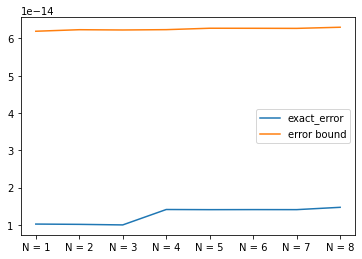

In [18]:
df_offline_online = df_offline_online.transpose()
df_offline_online.plot()

Il semblerait que pour $\mu=0.1$, la borne d'erreur $\Delta_N^{en}(\mu)$ soit supérieur à l'erreur exacte $||u(\mu)-u_N(\mu)||_X$ pour tous les valeurs de $N$.

### Question 4

In [19]:
# Case 2
def construct_mu(k_i,Bi):
    assert(k_i >= 0.1 and k_i <= 10)
    assert(Bi >= 0.01 and Bi <= 1)
    return np.array([k_i, k_i, k_i, k_i, 1., Bi])

D1=[0.1,10]
D2=[0.01,1.]
type='medium'
sample = 3
ortho = True
modele = reduce_basis(type,sample,mu_prod,ortho)

#### Question a

De la même manière que pour la question 3 précédente où l'on considérait le cas 1, on veut montrer ici que la méthode direct et la méthode offline/online nous donne les mêmes résultats pour la borne d'erreur d'énergie. 

##### Calcul direct

In [20]:
direct = direct_method(modele)

tab_k_i = np.sort(np.random.uniform(low=D1[0], high=D1[1], size=(5,)))
tab_Bi = np.sort(np.random.uniform(low=D2[0], high=D2[1], size=(5,)))
tab_mu = np.stack((tab_k_i,tab_Bi),axis=1)

tab_N = np.arange(1,modele.N+1,1)
res = np.zeros((modele.N,5))

for (i,n) in enumerate(tab_N):
    modele.change_N(n)
    for (j,(k_i,Bi)) in enumerate(tab_mu):
        mu = construct_mu(k_i,Bi)
        Delta_N_en_mu = direct.compute_Delta_N_en(mu)
        res[i,j] = Delta_N_en_mu

df_direct = pd.DataFrame(data=res,index=tab_N)
df_direct.columns = ["k_i = " + str(np.round(k_i,4)) + " ; Bi = " + str(np.round(Bi,4)) for (k_i,Bi) in tab_mu]
df_direct.index = ["N = " + str(n) for n in tab_N]

##### Offline/Online

In [21]:
offline_online = offline_online_method(modele)

res = np.zeros((modele.N,5))

for (i,n) in enumerate(tab_N):
    modele.change_N(n)
    Q_1,Q_2,Q_3 = offline_online.offline_quantity()

    for (j,(k_i,Bi)) in enumerate(tab_mu):
        mu = construct_mu(k_i,Bi)
        Delta_N_en_mu = offline_online.compute_Delta_N_en(mu,Q_1,Q_2,Q_3)
        res[i,j] = Delta_N_en_mu

df_offline_online = pd.DataFrame(data=res,index=tab_N)
df_offline_online.columns = ["k_i = " + str(np.round(k_i,4)) + " ; Bi = " + str(np.round(Bi,4)) for (k_i,Bi) in tab_mu]
df_offline_online.index = ["N = " + str(n) for n in tab_N]

##### Comparaison des 2 méthodes

In [22]:
print("Différence maximale (en valeur abs) des 2 méthodes :",(df_direct-df_offline_online).abs().max().max())

Différence maximale (en valeur abs) des 2 méthodes : 1.42013223630895e-08


Il semblerait donc que l'on obtienne bien les mêmes résultats pour la borne d'erreur d'énergie.

#### Question b

Nous allons utiliser dans la suite la méthode offline/online.

On veut maintenant calculer $\eta_{min,N}^{en}$, $\eta_{max,N}^{en}$ et $\eta_{ave,N}^{en}$ respectivement le minimum, le maximum et la moyenne de l'effectivité $\eta_{N}^{en}(\mu)$ sur $\Xi_{test}=\Xi_M^{test}=\Xi_M^{lin} \cup \Xi_M^{log}$. 

Avec
$$\Xi_M^{lin}=G_{[k_{min},k_{max};M]}^{lin}\times G_{[Bi_{min},Bi_{max};M]}^{lin}$$
et 
$$\Xi_M^{log}=G_{[k_{min},k_{max};M]}^{log}\times G_{[Bi_{min},Bi_{max};M]}^{log}$$

On prendra $M=10$ et $\Xi_{test}$ contiendra alors $2M^2=200$ points.

xi_test contient  200  points.


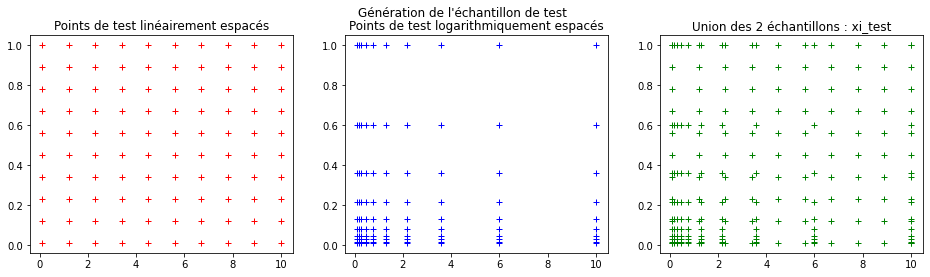

In [23]:
(k_i_min,k_i_max) = D1
(Bi_min,Bi_max) = D2
M=10

G_lin_k_i = np.linspace(k_i_min,k_i_max,M)
G_lin_Bi = np.linspace(Bi_min,Bi_max,M)
xi_lin = np.array(np.meshgrid(G_lin_k_i,G_lin_Bi)).T.reshape(-1,2)

G_log_k_i = np.logspace(np.log10(k_i_min),np.log10(k_i_max),M)
G_log_Bi = np.logspace(np.log10(Bi_min),np.log10(Bi_max),M)
xi_log = np.array(np.meshgrid(G_log_k_i,G_log_Bi)).T.reshape(-1,2)

xi_test = np.concatenate((xi_lin,xi_log),axis=0)

print("xi_test contient ",xi_test.shape[0]," points.")

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle("Génération de l'échantillon de test")

axs[0].plot(xi_lin[:,0],xi_lin[:,1],'+',color='red')
axs[0].set_title('Points de test linéairement espacés')
axs[1].plot(xi_log[:,0],xi_log[:,1],'+',color='blue')
axs[1].set_title('Points de test logarithmiquement espacés')
axs[2].plot(xi_test[:,0],xi_test[:,1],'+',color='green')
axs[2].set_title('Union des 2 échantillons : xi_test');

On considera les valeurs de $N$ suivantes : $5,10,20,30,40$.

In [24]:
offline_online = offline_online_method(modele)

tab_N = [5,10,20,30,40]
res = np.zeros((len(tab_N),4))

for (i,n) in enumerate(tab_N):
    modele.change_N(n)
    Q_1,Q_2,Q_3 = offline_online.offline_quantity()

    tab_eta_mu = []
    tab_mu = []
    for (j,(k_i,Bi)) in enumerate(xi_test):
        mu = construct_mu(k_i,Bi)
        eta_mu,exclude = offline_online.en_effectivity(mu,Q_1,Q_2,Q_3)
        if not exclude:
            tab_eta_mu.append(eta_mu)
            tab_mu.append(mu)

    argmax = np.argmax(tab_eta_mu)           
    eta_min,eta_max,eta_mean,bound = [np.min(tab_eta_mu),np.max(tab_eta_mu),np.mean(tab_eta_mu),compute_eff_en_bound(tab_mu[argmax])]
    res[i,:] = eta_min,eta_max,eta_mean,bound

# display(Latex('Calcul offline/online de $\Delta_N^{en}(\mu)$ pour différentes valeurs de $\mu$ et différents $N$ :'))
df_offline_online = pd.DataFrame(data=res,index=tab_N,columns=['min','max','mean','bound'])
df_offline_online.index = ["N = " + str(n) for n in tab_N]
df_offline_online

<ipython-input-4-de794dd27933>:17: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(val)


,min,max,mean,bound
N = 5,1.017255,6.685083,2.058090,9.433981
N = 10,1.031082,6.906718,2.135940,9.433981
N = 20,1.053642,6.896334,2.143211,9.433981
N = 30,1.054003,7.032357,1.998226,9.433981
N = 40,1.043994,6.584124,1.945547,9.433981


D'après le cours, nous avons la propriété suivante :
$$1\le \eta_{N}^{en}(\mu)\le\sqrt{\frac{\gamma_{UB}(\mu)}{\alpha_{LB}(\mu)}}$$

On constate bien que l'effectivité minimale dans le tableau ci-dessus est supérieur à 1.

De plus, on constate que toutes les bornes calculées ici sont inférieures à la borne calculée dans la question 1.b. 
En effet, pour la borne associée à la norme d'énergie, dans le cas 2, cette borne est égale à $10$.

## Part 3 - Reduced Basis Output Bound

Étant donné la borne d'erreur d'énergie de la partie 2, nous pouvons maintenant évaluer directement la borne d'erreur de sortie.

### Question 5

In [25]:
# Case 2
def construct_mu(k_i,Bi):
    assert(k_i >= 0.1 and k_i <= 10)
    assert(Bi >= 0.01 and Bi <= 1)
    return np.array([k_i, k_i, k_i, k_i, 1., Bi])

D1=[0.1,10]
D2=[0.01,1.]
type='medium'
sample = 3
ortho = True
modele = reduce_basis(type,sample,mu_prod,ortho)

#### Question a

On définit $\Delta_N^{s}(\mu)$ la borne d'erreur de sortie par :
$$\boxed{\Delta_N^{s}(\mu)=\Delta_N^{en}(\mu)^2}$$

et l'effectivité associée :
$$\boxed{\eta_{N}^{s}(\mu)=\frac{\Delta_N^{s}(\mu)}{s(\mu)-s_N(\mu)}}$$

On va étendre le code dans la partie **Classes et fonctions** pour calculer également ces deux quantités.

#### Question b

In [26]:
(k_i_min,k_i_max) = D1
(Bi_min,Bi_max) = D2
M=10

G_lin_k_i = np.linspace(k_i_min,k_i_max,M)
G_lin_Bi = np.linspace(Bi_min,Bi_max,M)
xi_lin = np.array(np.meshgrid(G_lin_k_i,G_lin_Bi)).T.reshape(-1,2)

G_log_k_i = np.logspace(np.log10(k_i_min),np.log10(k_i_max),M)
G_log_Bi = np.logspace(np.log10(Bi_min),np.log10(Bi_max),M)
xi_log = np.array(np.meshgrid(G_log_k_i,G_log_Bi)).T.reshape(-1,2)

xi_test = np.concatenate((xi_lin,xi_log),axis=0)

In [27]:
offline_online = offline_online_method(modele)

tab_N = [5,10,20,30,40]
res = np.zeros((len(tab_N),4))

for (i,n) in enumerate(tab_N):
    modele.change_N(n)
    Q_1,Q_2,Q_3 = offline_online.offline_quantity()

    tab_eta_mu = []
    tab_mu = []
    for (j,(k_i,Bi)) in enumerate(xi_test):
        mu = construct_mu(k_i,Bi)
        eta_mu,exclude = offline_online.s_effectivity(mu,Q_1,Q_2,Q_3)
        if not exclude:
            tab_eta_mu.append(eta_mu)
            tab_mu.append(mu)

    argmax = np.argmax(tab_eta_mu)           
    eta_min,eta_max,eta_mean,bound = [np.min(tab_eta_mu),np.max(tab_eta_mu),np.mean(tab_eta_mu),compute_eff_out_bound(tab_mu[argmax])]
    res[i,:] = eta_min,eta_max,eta_mean,bound

# display(Latex('Calcul offline/online de $\Delta_N^{en}(\mu)$ pour différentes valeurs de $\mu$ et différents $N$ :'))
df_offline_online = pd.DataFrame(data=res,index=tab_N,columns=['min','max','mean','bound'])
df_offline_online.index = ["N = " + str(n) for n in tab_N]
df_offline_online

<ipython-input-4-de794dd27933>:17: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(val)


,min,max,mean,bound
N = 5,1.034808,44.690339,5.104766,89.0
N = 10,1.063130,47.702585,5.730602,89.0
N = 20,1.110162,45.284882,5.427732,89.0
N = 30,1.110923,45.414228,4.813504,89.0
N = 40,1.089926,6.698566,2.899911,10.0


D'après le cours, nous avons la propriété suivante :
$$1\le \eta_{N}^{s}(\mu)\le\frac{\gamma_{UB}(\mu)}{\alpha_{LB}(\mu)}$$

On constate bien que l'effectivité minimale dans le tableau ci-dessus est supérieur à 1.

De plus, l'effectivité maximale est bien inférieure à la borne et on constate que toutes les bornes calculées ici sont inférieures à la borne calculée dans la question 1.b. 
En effet, pour la borne associée à la sortie, dans le cas 2, cette borne est égale à $100$.

#### Question c

On cherche à déterminer quelle valeur de N il faut pour obtenir une précision relative de la borne de sortie d'environ 1%. On calculera également l'erreur réelle pour cette valeur de N.

In [28]:
(k_i_min,k_i_max) = D1
(Bi_min,Bi_max) = D2
M=10

G_lin_k_i = np.linspace(k_i_min,k_i_max,M)
G_lin_Bi = np.linspace(Bi_min,Bi_max,M)
xi_lin = np.array(np.meshgrid(G_lin_k_i,G_lin_Bi)).T.reshape(-1,2)

G_log_k_i = np.logspace(np.log10(k_i_min),np.log10(k_i_max),M)
G_log_Bi = np.logspace(np.log10(Bi_min),np.log10(Bi_max),M)
xi_log = np.array(np.meshgrid(G_log_k_i,G_log_Bi)).T.reshape(-1,2)

xi_test = np.concatenate((xi_lin,xi_log),axis=0)

In [29]:
n=0
accuracy=1
while accuracy>0.01:
    n+=1
    modele.change_N(n)
    tab_accuracy = []
    for (j,(k_i,Bi)) in enumerate(xi_test):
        mu = construct_mu(k_i,Bi)
        s_mu = modele.get_T_root_N_cal(mu)
        s_N_mu = modele.get_T_root_N(mu)
        tab_accuracy.append(np.abs(s_mu-s_N_mu))
    accuracy = np.max(tab_accuracy)
print("Pour N = ",n," l'accuracy est inférieure à 1%.")


Pour N =  10  l'accuracy est inférieure à 1%.


In [30]:
tab_true_error = []
for (k_i,Bi) in xi_test:
    mu = construct_mu(k_i,Bi)
    T_root_N = modele.get_T_root_N(mu)
    T_root_N_cal = modele.get_T_root_N_cal(mu)
    tab_true_error.append(np.abs(T_root_N-T_root_N_cal))
print("Le maximum de la vraie erreur associée à N = ",n," est : ",np.max(tab_true_error))

Le maximum de la vraie erreur associée à N =  10  est :  0.004031532517373648


#### Question d

On cherche à comparer le temps d'exécution pour calculer $\Delta_N^s(\mu)$ avec le temps pour calculer $s_N(\mu)$ sur notre échantillon par rapport à $N$.

In [31]:
offline_online = offline_online_method(modele)

tab_delta_N_en = [] 
tab_s_N = []
for n in range(modele.N):
    modele.change_N(n+1)
    Q_1,Q_2,Q_3 = offline_online.offline_quantity()
    
    deb = time.time()
    for (k_i,Bi) in xi_test:
        mu = construct_mu(k_i,Bi)
        offline_online.compute_Delta_N_en(mu,Q_1,Q_2,Q_3)
    fin = time.time()
    tab_delta_N_en.append(fin-deb)

    deb = time.time()
    for (k_i,Bi) in xi_test:
        T_root_N = modele.get_T_root_N(mu)
    fin = time.time()
    tab_s_N.append(fin-deb)


<ipython-input-4-de794dd27933>:17: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(val)


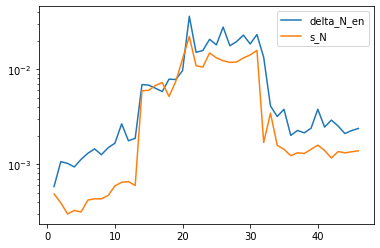

In [32]:
tab_N = np.arange(1,modele.N+1,1)
plt.plot(tab_N,[delta_N_en/len(xi_test) for delta_N_en in tab_delta_N_en],label='delta_N_en')
plt.plot(tab_N,[s_N/len(xi_test) for s_N in tab_s_N],label='s_N')
plt.yscale('log')
plt.legend()

#### Question e

On cherche à comparer les temps d'exécution pour calculer $\Delta_N^s(\mu)$, $s_N(\mu)$ et $s(\mu)$ sur notre échantillon par rapport à $N$.

In [33]:
offline_online = offline_online_method(modele)

tab_s = []
for n in range(modele.N):
    deb = time.time()
    for (k_i,Bi) in xi_test:
        T_root_N_cal = modele.get_T_root_N_cal(mu)
    fin = time.time()
    tab_s.append(fin-deb)

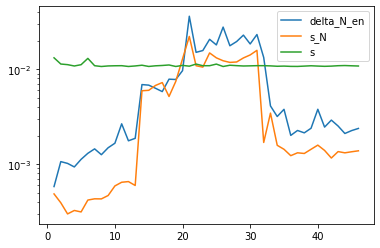

In [34]:
tab_N = np.arange(1,modele.N+1,1)
plt.plot(tab_N,[delta_N_en/len(xi_test) for delta_N_en in tab_delta_N_en],label='delta_N_en')
plt.plot(tab_N,[s_N/len(xi_test) for s_N in tab_s_N],label='s_N')
plt.plot(tab_N,[s/len(xi_test) for s in tab_s],label='s')
plt.yscale('log')
plt.legend()

## Part 4 - Greedy Sampling Procedure

In [35]:
# to convert the algorithm from md to pdf
# !pandoc greedy_algorithm.md -o greedy_algorithm.pdf

Nous allons maintenant nous tourner vers la procédure d'échantillonnage gloutonne (Greedy Sampling Procedure) dans le but de construire les jeux d'échantillons $S_N$. Voici l'algorithme :

<img src="greedy_algorithm.png" width="500"/>

Nous choisirons ici
$$w(\mu)=|||u_N(\mu)|||_\mu, \quad \epsilon_{tol}=10e-6 \quad \text{ et } \quad S_1=\mu_{\min}$$


Notons que après la mise à jour $S_N=S_{N-1}\cup\{\mu_N\}$, nous devons calculer $u(\mu_N)$ pour construire (en utilisant Gram-Schmidt) la nouvelle contribution à notre ensemble de base **orthonormal** $\xi_N$ pour former $X_N$.

Pour faire celà, nous commençons par modifier légèrement le constructeur de la classe `reduce_basis` afin de pouvoir initialiser l'échantillon sans le charger depuis le fichier "RB_sample.mat" mais en lui donnant une valeur de $\mu$. Pour celà, il faudra mettre sample à 0 et lui donner le $\mu$ initial. 

On va ensuite rajouter une méthode **one_step_greedy** qui effectuera une étape de l'agorithme Greedy. On pourra également lui donner en paramètre l'argument normalize, si il est à False nous metterons la fonction $w(\mu)$ à 1.

La fonction **greedy_algorithm** suivante va effectuer toutes les itérations nécessaires de Greedy en appelant la méthode *one_step_greedy*.

In [36]:
def greedy_algorithm(method,mu_1,mu_train,eps_tol,normalize=True):
    if isinstance(method,direct_method):
        method_name="direct"
    elif isinstance(method,offline_online_method):
        method_name="offline_online"

    Delta_N_max = 1
    tab_mu_N = []
    while Delta_N_max >= eps_tol:
        print("N = ",method.modele.N," ; Delta_N_max = ",Delta_N_max)
        Delta_N_max,mu_N = method.modele.one_step_greedy(method,method_name,mu_train,normalize)
        tab_mu_N.append((mu_N,Delta_N_max))
    tab_mu_N.append(None)

    return tab_mu_N

### Question 6

In [37]:
# Case 1
def construct_mu(k_i):
    Bi = 0.1
    assert(k_i >= 0.1 and k_i <= 10)
    return np.array([k_i, k_i, k_i, k_i, 1., Bi])

D=[0.1,10]
type='medium'
xi_train = np.logspace(np.log10(D[0]),np.log10(D[1]),100)
mu_train = np.array([construct_mu(k_i) for k_i in xi_train])
mu_1 = construct_mu(D[0])
S_1 = np.array([mu_1])
sample=0
eps_tol=1e-6

modele=reduce_basis(type,sample,mu_prod,S_N=S_1)
method=offline_online_method(modele)

normalize=True

#### Question a

On cherche à déterminer quelle est valeur de $N_{max}$ nous permettant d'atteindre la précision souhaitée. 

In [38]:
tab_mu_N = greedy_algorithm(method,mu_1,mu_train,eps_tol,normalize)

N =  1  ; Delta_N_max =  1
N =  2  ; Delta_N_max =  3.0857073627010965
N =  3  ; Delta_N_max =  0.1931407880672572
N =  4  ; Delta_N_max =  0.040042452359177534
N =  5  ; Delta_N_max =  0.0051538918804122655
N =  6  ; Delta_N_max =  0.001225461264801626
N =  7  ; Delta_N_max =  0.0006669737144878806
N =  8  ; Delta_N_max =  1.488164990296409e-05
N =  9  ; Delta_N_max =  4.186368006808741e-06


In [39]:
print("N_max = ",method.modele.N)

N_max =  10


Nous allons à présent plot pour chaque $N$ compris entre $1$ et $N_{max}$, l'erreur relative $||u(\mu)-u_N(\mu)||_\mu/||u_N(\mu)||_\mu$ et l'erreur relative de la borne d'énergie $\Delta_N^{en}(\mu)/||u_N(\mu)||_\mu$ pour $\mu\in\Xi^{train}$. Dans chacune des figures, nous marquerons d'un point le paramètre choisi par l'algorithme de Greedy.

In [40]:
def compute_values(method,mu_train,normalize=True):
    tab_relative_error = []
    tab_en_bound = []
    
    for n in range(method.modele.N):
        method.modele.change_N(n+1)

        Z = method.modele.Z

        if isinstance(method,offline_online_method):
            Q_1,Q_2,Q_3 = method.offline_quantity()

        tab_relative_error_n = []
        tab_en_bound_n = []
        for mu in mu_train:
            u_N = method.modele.get_u_N(mu)
            Zu_N = Z@u_N

            A_N_cal = method.modele.get_A_N_cal(mu)
            F_N_cal = method.modele.F_N_cal
            u_N_cal = spsolve(A_N_cal, F_N_cal)

            if normalize==True:
                den = np.sqrt(Zu_N.T @ A_N_cal @ Zu_N)
            else:
                den = 1

            e = u_N_cal-Zu_N
            relative_error = np.sqrt(e.T @ A_N_cal @ e)/den
            tab_relative_error_n.append(relative_error)

            if isinstance(method,direct_method):
                Delta_N_en_mu = method.compute_Delta_N_en(mu)
            elif isinstance(method,offline_online_method):
                Delta_N_en_mu = method.compute_Delta_N_en(mu,Q_1,Q_2,Q_3)
            en_bound = Delta_N_en_mu/den
            tab_en_bound_n.append(en_bound)

        tab_relative_error.append(tab_relative_error_n)
        tab_en_bound.append(tab_en_bound_n)

    return tab_relative_error,tab_en_bound

tab_relative_error,tab_en_bound = compute_values(method,mu_train,normalize)

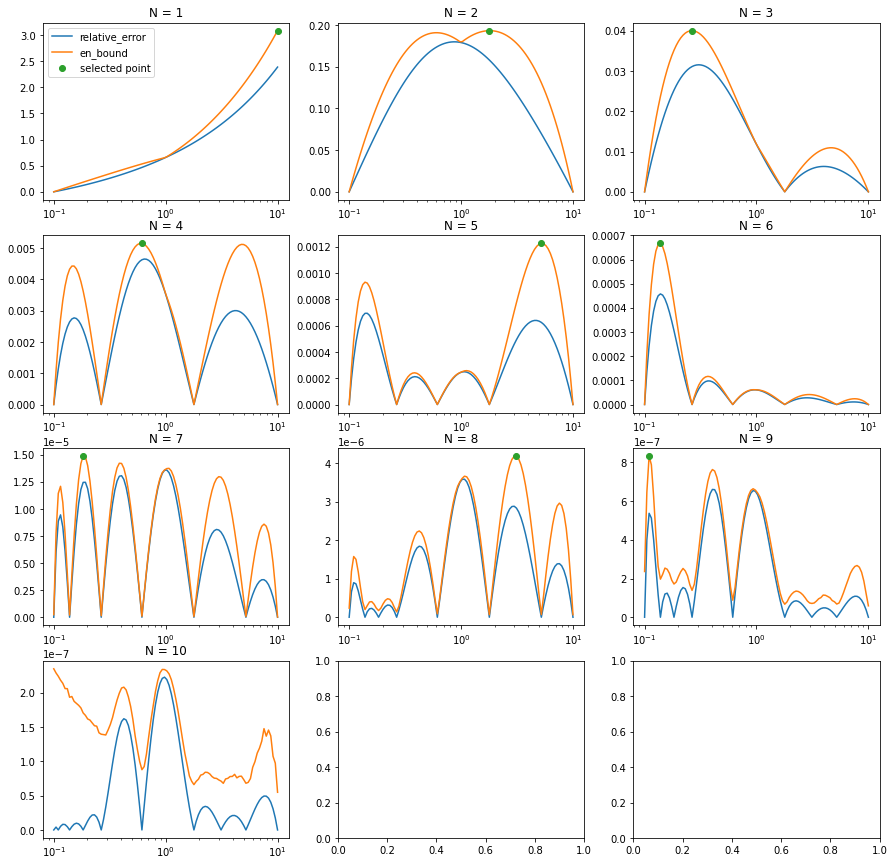

In [41]:
nb_lignes = method.modele.N//3
reste = method.modele.N%3
if reste!=0:
    nb_lignes+=1

fig, axs = plt.subplots(nb_lignes, 3, figsize=(15, 5*(nb_lignes-1)))

l=0
for n in range(method.modele.N):
    c = n%3
    axs[l][c].plot(xi_train,tab_relative_error[n],label='relative_error')
    axs[l][c].plot(xi_train,tab_en_bound[n],label='en_bound')
    if tab_mu_N[n]!=None:
        axs[l][c].plot(tab_mu_N[n][0][0],tab_mu_N[n][1],'o',label='selected point')
    axs[l][c].set_xscale('log')
    axs[l][c].set_title("N = "+str(n+1))
    if c==2:
        l+=1
axs[0][0].legend();

#### Question b

Nous allons maintenant plot $\Delta_N^{max}$ en fonction de $N$.

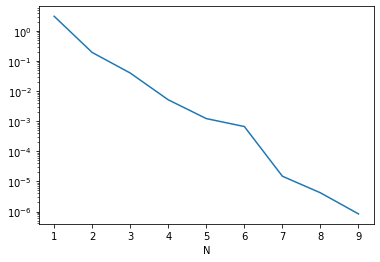

In [42]:
tab_N = np.arange(1,method.modele.N,1)
tab_Delta_N_max = np.array([tab_mu_N[n][1] for n in range(method.modele.N-1)])
plt.plot(tab_N,tab_Delta_N_max,label='relative_error')
plt.yscale('log')
plt.xlabel("N");

#### Question c

Nous considérons maintenant deux nouveaux échantillons : $S_N^{lin}=G_{[\mu_{min},\mu_{max};N]}^{lin}$ et $S_N^{log}=G_{[\mu_{min},\mu_{max};N]}^{log}$ avec $N$ variant de 2 à $N_{max}$. 

Nous aimerions comparer les convergences de l'approximation base réduite utilisant l'algorithme de Greedy avec celle utilisant l'échantillon linéaire et celle utilisant l'échantillon logarithmique. 

Nous allons plot sur une même figure le maximum de l'erreur relative pour la norme d'énergie $\max_{\mu\in\Xi_{test}}||u(\mu)-u_N(\mu)||_\mu/||u_N(\mu)||_\mu$ pour les 3 cas avec $\Xi_{test}=G_{[\mu_{min},\mu_{max};50]}^{lin}\cup G_{[\mu_{min},\mu_{max};50]}^{log}$.

In [43]:
def compute_max_relative_error(method,mu_test,normalize=True):
    Z = method.modele.Z

    tab_relative_error = []
    for mu in mu_test:
        u_N = method.modele.get_u_N(mu)
        Zu_N = Z@u_N

        A_N_cal = method.modele.get_A_N_cal(mu)
        F_N_cal = method.modele.F_N_cal
        u_N_cal = spsolve(A_N_cal, F_N_cal)

        if normalize==True:
            den = np.sqrt(Zu_N.T @ A_N_cal @ Zu_N)
        else:
            den = 1

        e = u_N_cal-Zu_N
        relative_error = np.sqrt(e.T @ A_N_cal @ e)/den
        tab_relative_error.append(relative_error)

    return np.max(tab_relative_error)
    

In [44]:
N_max = method.modele.N

sample = 0
modele_greedy = reduce_basis(type,sample,mu_prod,S_N=S_1)
method_greedy = offline_online_method(modele)

sample = 4
ortho = True

k_i_lin = np.linspace(D[0],D[1],N_max)
S_lin_complet = np.array([construct_mu(k_i) for k_i in k_i_lin])
modele_lin = reduce_basis(type,sample,mu_prod,ortho=ortho,S_N=S_lin_complet)
method_lin = offline_online_method(modele_lin)

k_i_log = np.logspace(np.log10(D[0]),np.log10(D[1]),N_max)
S_log_complet = np.array([construct_mu(k_i) for k_i in k_i_log])
modele_log = reduce_basis(type,sample,mu_prod,ortho=ortho,S_N=S_log_complet)
method_log = offline_online_method(modele_log)

M = 50
G_lin = np.linspace(D[0],D[1],M)
G_log = np.logspace(np.log10(D[0]),np.log10(D[1]),M)
xi_test = np.sort(np.concatenate((G_lin,G_log)))[2:-2]
mu_test = np.array([construct_mu(k_i) for k_i in xi_test])

tab_relative_error_greedy = []
tab_relative_error_lin = []
tab_relative_error_log = []
for n in range(N_max):
    print("N = ",n+1)
    method_greedy.modele.change_N(n+1)
    tab_relative_error_greedy.append(compute_max_relative_error(method_greedy,mu_test,normalize))

    method_lin.modele.change_N(n+1)
    tab_relative_error_lin.append(compute_max_relative_error(method_lin,mu_test,normalize))

    method_log.modele.change_N(n+1)
    tab_relative_error_log.append(compute_max_relative_error(method_log,mu_test,normalize))

N =  1
N =  2
N =  3
N =  4
N =  5
N =  6
N =  7
N =  8
N =  9
N =  10


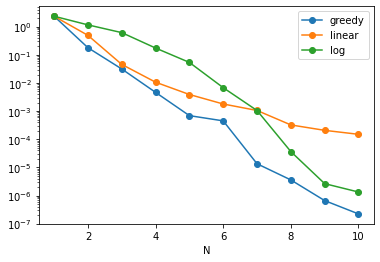

In [45]:
tab_N = np.arange(1,N_max+1,1)
plt.plot(tab_N,tab_relative_error_greedy,"o-",label='greedy')
plt.plot(tab_N,tab_relative_error_lin,"o-",label='linear')
plt.plot(tab_N,tab_relative_error_log,"o-",label='log')
plt.yscale('log')
plt.xlabel("N")
plt.legend();

### Question 7

In [46]:
# Case 2
def construct_mu(k_i,Bi):
    assert(k_i >= 0.1 and k_i <= 10)
    assert(Bi >= 0.01 and Bi <= 1)
    return np.array([k_i, k_i, k_i, k_i, 1., Bi])

D1=[0.1,10]
D2=[0.01,1.]

type='medium'
M=25
G_log_k_i = np.logspace(np.log10(D1[0]),np.log10(D1[1]),M)
G_log_Bi = np.logspace(np.log10(D2[0]),np.log10(D2[1]),M)
xi_log = np.array(np.meshgrid(G_log_k_i,G_log_Bi)).T.reshape(-1,2)
mu_train = np.array([construct_mu(k_i,Bi) for (k_i,Bi) in xi_log])

mu_1 = construct_mu(xi_log[0][0],xi_log[0][1])
S_1 = np.array([mu_1])
sample=0
eps_tol=10e-6

modele=reduce_basis(type,sample,mu_prod,S_N=S_1)
method=offline_online_method(modele)

normalize=True


#### Question a

On cherche à déterminer quelle est la valeur de $N_{max}$ nous permettant d'atteindre la précision souhaitée.

In [47]:
tab_mu_N = greedy_algorithm(method,mu_1,mu_train,eps_tol,normalize)

N =  1  ; Delta_N_max =  1
N =  2  ; Delta_N_max =  10.39856314933044


<ipython-input-4-de794dd27933>:17: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(val)


N =  3  ; Delta_N_max =  8.191997411172466
N =  4  ; Delta_N_max =  2.2933554486734695
N =  5  ; Delta_N_max =  1.0464819450953533
N =  6  ; Delta_N_max =  0.49623923546685067
N =  7  ; Delta_N_max =  0.22134903344610574
N =  8  ; Delta_N_max =  0.18140166231314916
N =  9  ; Delta_N_max =  0.1299740139346109
N =  10  ; Delta_N_max =  0.08878915129722526
N =  11  ; Delta_N_max =  0.07838024761273127
N =  12  ; Delta_N_max =  0.037398495045526156
N =  13  ; Delta_N_max =  0.03268852455951338
N =  14  ; Delta_N_max =  0.023449725211420767
N =  15  ; Delta_N_max =  0.01650169288552049
N =  16  ; Delta_N_max =  0.00985657938631095
N =  17  ; Delta_N_max =  0.009296997475144406
N =  18  ; Delta_N_max =  0.006962947809241184
N =  19  ; Delta_N_max =  0.0037310031645201
N =  20  ; Delta_N_max =  0.0033877023260534874
N =  21  ; Delta_N_max =  0.0027022249720372233
N =  22  ; Delta_N_max =  0.0024122408737173367
N =  23  ; Delta_N_max =  0.0015390118340108487
N =  24  ; Delta_N_max =  0.0011970

In [48]:
print("N_max = ",method.modele.N)

N_max =  43


#### Question b

Nous allons maintenant plot $\Delta_N^{max}$ en fonction de $N$.

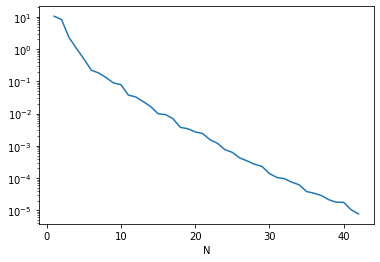

In [49]:
tab_N = np.arange(1,method.modele.N,1)
tab_Delta_N_max = np.array([tab_mu_N[n][1] for n in range(method.modele.N-1)])
plt.plot(tab_N,tab_Delta_N_max,label='relative_error')
plt.yscale('log')
plt.xlabel("N");

#### Question c

Nous allons plot notre échantillon $S_N$ en échelle loglog.

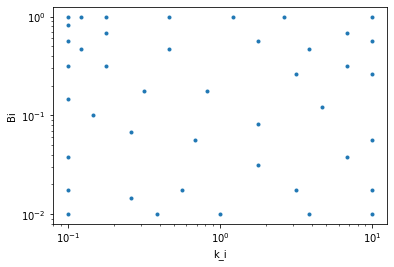

In [50]:
S_N = method.modele.S_N
k_i = S_N[:,0]
Bi = S_N[:,-1]
plt.loglog(k_i,Bi,".",label='S_N')
plt.xlabel("k_i")
plt.ylabel("Bi");

#### Question d

Nous allons plot le maximum de l'erreur relative pour la norme d'énergie $\max_{\mu\in\Xi_{test}}||u(\mu)-u_N(\mu)||_\mu/||u_N(\mu)||_\mu$ et le maximum de l'erreur de sortie $\max_{\mu\in\Xi_{test}}|T_{root}(\mu)-T_{root,N}(\mu)|/T_{root}(\mu)$ avec $\Xi_{test}=G_{[\mu_{min},\mu_{max};10]}^{lin}\cup G_{[\mu_{min},\mu_{max};10]}^{log}$.

In [51]:
def compute_values(method,mu_test,normalize=True):
    Z = method.modele.Z

    tab_relative_error = []
    tab_relative_out_error = []
    for mu in mu_test:
        u_N = method.modele.get_u_N(mu)
        Zu_N = Z@u_N
        T_root_N = method.modele.L_N.T @ u_N

        A_N_cal = method.modele.get_A_N_cal(mu)
        F_N_cal = method.modele.F_N_cal
        u_N_cal = spsolve(A_N_cal, F_N_cal)
        T_root_N_cal = method.modele.L_N_cal.T @ u_N_cal

        if normalize==True:
            den = np.sqrt(Zu_N.T @ A_N_cal @ Zu_N)
            den2 = np.abs(T_root_N)
        else:
            den = 1
            den2 = 1

        e = u_N_cal-Zu_N
        relative_error = np.sqrt(e.T @ A_N_cal @ e)/den
        tab_relative_error.append(relative_error)

        tab_relative_out_error.append(np.abs(T_root_N_cal-T_root_N)/den2)

    return np.max(tab_relative_error),np.max(tab_relative_out_error)

In [52]:
N_max = method.modele.N

(k_i_min,k_i_max) = D1
(Bi_min,Bi_max) = D2
M=10

G_lin_k_i = np.linspace(k_i_min,k_i_max,M)
G_lin_Bi = np.linspace(Bi_min,Bi_max,M)
xi_lin = np.array(np.meshgrid(G_lin_k_i,G_lin_Bi)).T.reshape(-1,2)

G_log_k_i = np.logspace(np.log10(k_i_min),np.log10(k_i_max),M)
G_log_Bi = np.logspace(np.log10(Bi_min),np.log10(Bi_max),M)
xi_log = np.array(np.meshgrid(G_log_k_i,G_log_Bi)).T.reshape(-1,2)

xi_test = np.concatenate((xi_lin,xi_log),axis=0)
mu_test = np.array([construct_mu(k_i,Bi) for (k_i,Bi) in xi_test])

In [53]:
tab_max_relative_error = []
tab_max_relative_out_error = []
for n in range(N_max):
    print("N = ",n+1)
    method.modele.change_N(n+1)
    max_relative_error,max_relative_out_error = compute_values(method,mu_test,normalize)
    tab_max_relative_error.append(max_relative_error)
    tab_max_relative_out_error.append(max_relative_out_error)

N =  1
N =  2
N =  3
N =  4
N =  5
N =  6
N =  7
N =  8
N =  9
N =  10
N =  11
N =  12
N =  13
N =  14
N =  15
N =  16
N =  17
N =  18
N =  19
N =  20
N =  21
N =  22
N =  23
N =  24
N =  25
N =  26
N =  27
N =  28
N =  29
N =  30
N =  31
N =  32
N =  33
N =  34
N =  35
N =  36
N =  37
N =  38
N =  39
N =  40
N =  41
N =  42
N =  43


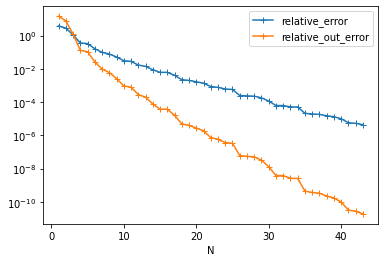

In [54]:
tab_N = np.arange(1,method.modele.N+1,1)
plt.plot(tab_N,tab_max_relative_error,"+-",label='relative_error')
plt.plot(tab_N,tab_max_relative_out_error,"+-",label='relative_out_error')
plt.yscale('log')
plt.xlabel("N")
plt.legend();